In [2]:
# Statistically significant cutoff.
alpha = 0.05
m = 2*6*5 + 2*13
alpha = alpha * (1-(1 - alpha)**(m))

In [3]:
alpha

0.04939298411094704

In [4]:
import pickle as pkl
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys
sys.path.insert(1, '/home/NearingLab/projects/jmframe/lstm_camels/tools/')
import metrics
import signatures
import corrstats #https://github.com/psinger/CorrelationStats/blob/master/corrstats.py

import scipy
import scipy.stats as st
import statsmodels as sm

# For the regression.
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import xarray as xr

In [5]:
proj_dir = '/home/NearingLab/projects/jmframe/lstm_camels/'
data_dir = proj_dir + 'data/'
nldas_dir = data_dir + 'basin_dataset_public_v1p2/basin_mean_forcing/nldas_extended/'

openthis = '/home/NearingLab/projects/jmframe/lstm_camels/data/calibrated_basins.txt'
calibrated_basins = pd.read_csv(openthis)
cb = calibrated_basins['Domain_Meta.gage_id'].values

In [6]:
dynamic_plots = False
# this command is executed twice for interactive plotting in Jupyter notebook
if dynamic_plots:
    %matplotlib notebook
    %matplotlib notebook

In [7]:
# Get all the metrics available in one list.
mets = metrics.get_available_metrics()
nmets = len(mets)

In [57]:
#####################################
calculate_metric_dictionary = False##
calculate_flow_categories = False  ##
calculate_metric_matrix = False    ##
#####################################


# Definitions
base_models=['nwm','v0']
area_index='area_geospa_fabric'
sample_basin = '11532500'
drop_these = ['high_prec_timing','root_depth_50',
              'root_depth_99','zero_q_freq','water_frac','organic_frac']

val_start='1994-10-01'
val_end='2003-09-30'
date_range = pd.date_range(start=val_start, end=val_end)

sample_lstm_run = 'runs/run_1103_121106_seed83357/lstm_seed83357_statclimtest.p'


# A list of all the run types. LSTM version numbers explained in comments above
nwm_lstm_version_list = ['nwm', 'v0', 'v1', 'v2', 'v2x']
plot_model_names = ['LSTM', 'LSTM+NWM', 'NWM (1 day)']
plot_models = ['control', 'test', 'NWM_all_forcings']
base_model_names = ['NWM (1 day)', 'LSTM']
display_model_names = {'v0':'LSTM w/o NWM', 'v2':'LSTM w NWM', 'nwm':'NWM (1 day)'}
model_type_list_for_corr = ['NWM', 'LSTM', 'LSTM w/ NWM', 'LSTM+NWMx']
model_name_list_for_corr = ['nwm', 'v0', 'v2', 'v2x']


obs_model_types = ['obs', 'nwm', 'v0', 'v2']


model_types = ['nwm', 'v0', 'v2']
model_types2 = ['NWM', 'LSTM', 'LSTM w/ NWM']
combined_metric_list = ['nse', 'bias', 'variance', 'pearsonr']


use_metrics = ['NSE', 'Beta-NSE', 'Peak-Timing']
metric_names = ['Nash-Sutcliffe Efficiency', 'Total bias', 'Peak timing error']
short_metric_names = ['NSE', 'Bias', 'Timing']
use_metric_names = ['Nash-Sutcliffe Efficiency', 'Total bias', 'Peak timing error']
use_metric_locs = [0,6,11]


flow_categories = ['all', 'rise', 'fall','above_mean', 'below_mean',
                       'above_mid', 'below_mid', 'below_20', 'above_80']
flow_categories_slim = ['all', 'rise' , 'fall','below_20', 'above_80']

flow_categories_very_slim = ['all', 'rise' , 'fall']

In [9]:
if True: # Open the attributes from the coding workshop. These are already set up to do regression
    openthis = '/home/NearingLab/data/camels_all_coding_workshop.csv'
    attributes = pd.read_csv(openthis, sep=',', index_col='gauge_id')
else: # Open a slightly more extrnsive data set.
    openthis = '/home/NearingLab/data/camels_attributes_v2.0/camels_all.txt'
    attributes = pd.read_csv(openthis, sep=';', index_col='gauge_id')
    
# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
attributes['basin_id_str'] = basin_id_str

# These are bad for the regression analysis.
attributes = attributes.drop(drop_these, axis=1)

In [10]:
# Get the hydrologic units for each basin.
with open(data_dir + 'usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
attributes['basin_hydro_unit'] = basin_hydro_unit

In [11]:
basin_list = []
with open(proj_dir+'data/basin_list.txt', 'r') as f:
    for line in f:
        basin_list.append(str(line[0:8]))
nbasins = len(basin_list)

In [12]:
attributes['calibrated'] = [np.nan]*attributes.shape[0]
calibrated_basins_list = []
for ib, b in enumerate(basin_list):
    if b in cb:
        calibrated_basins_list.append(b)
        attributes.loc[int(b), 'calibrated'] = True
    else:
        attributes.loc[int(b), 'calibrated'] = False

In [13]:
with open('calibrated_basin_list.txt', 'w') as f:
    for b in calibrated_basins_list:
        f.write('%s\n' % b)

In [14]:
# Convert NWM streamflow (m3/s) to mm
sid = 60*60*24 # seconds in day
mikm = 0.001 # meter in kilometer
mmim = 0.001 # millimeter in meter

In [15]:
# LSTM
v0 = ['run_1103_121106_seed83357', 'run_1103_113114_seed604500', 
      'run_1103_121501_seed484165', 'run_1203_181142_seed398144',
      'run_1203_181142_seed602441', 'run_1203_181142_seed712381',
      'run_2402_183736_seed785305', 'run_1906_161642_seed785306',
      'run_1806_082707_seed785307', 'run_1806_054617_seed785308']

# LSTM + NWM V1
v1 = ['run_1803_161443_seed604500', 'run_2003_191127_seed83357',
      'run_1203_083616_seed484165', 'run_1203_182238_seed398144',
      'run_1203_182238_seed602441', 'run_1203_182238_seed712381',
      'run_2502_083546_seed785305']

#final with RT values
v2 = ['run_0806_123405_seed83357', 'run_0806_233426_seed604500',
      'run_0906_004032_seed398144', 'run_0906_235116_seed484165',
      'run_1206_102325_seed712381', 'run_1206_173942_seed602441',
      'run_1506_111315_seed785305', 'run_1506_221658_seed785306',
      'run_1606_045259_seed785307', 'run_1606_155403_seed785308']
v2x = ['run_2306_104142_seed83357']


dict_ensembles = {'v0':v0, 'v1':v1, 'v2':v2}
#df_ensembles = pd.DataFrame({'v0':v0, 'v1':v1, 'v2':v2})
#nruns = len(seed)

In [16]:
# open a sample of a LSTM run, to get the observation values
openthis = proj_dir+sample_lstm_run
with open(openthis, 'rb') as f:
    lstm_sample = pkl.load(f)

In [17]:
# NWM Reanalysis
openthis = proj_dir+'data/nwm_chrt_v2_1d_local.p'
with open(openthis, 'rb') as f:
    nwm = pkl.load(f)

In [18]:
# Empty metrics array, to fill in a dictionary with the different run version, and basins.
empty_metrics_array = np.full([nbasins,nmets],np.nan)

# An empty dictionary of basins, to then put in a dictionary of flow types
empty_basins_q_dictionary = {b:np.full(nwm[b]['streamflow'].shape, np.nan) for b in basin_list}

# This will have the ensemble mean flow for each simulation type
ensemble_q_dictionary = {rt:empty_basins_q_dictionary for rt in nwm_lstm_version_list}

In [19]:
# Convert the NWM streamflow (m3/s) to surface runoff (mm)
for i, b in enumerate(basin_list):
    A = attributes.loc[int(b), area_index]
    conversion_factor = sid * mmim / A
    ensemble_q_dictionary['nwm'][b] = conversion_factor * nwm[b]['streamflow']

In [20]:
# Get the streamflow predictions for a specific run instance
def get_streamflow_prediction(specifc_run):
    # Get the seed from the run name
    seed = specifc_run.split('seed')[1]
    
    flow_dict = {b:empty_basins_q_dictionary for b in basin_list}
    seed = str(seed)
    openthis = proj_dir+'runs/'+specifc_run+'/lstm_seed'+seed+'_statclimtest.p'
    with open(openthis, 'rb') as f:
        temp_simulation_file = pkl.load(f)
    
    for i, b in enumerate(basin_list):
        flow_dict[b] = temp_simulation_file[b].loc[date_range, 'qsim']

    return flow_dict

In [21]:
# Combined all the ensemble flows into ONE mean ensemble flow.
# loop through the simulation types
seed_discrepancies = {'v0':[],'v1':[],'v2':[]}
for sim_type in dict_ensembles.keys():
    print(sim_type)
    # get the number of ensemble members
    n_ensemble_members = len(dict_ensembles[sim_type])
    # Loop through each ensemble member
    for em in range(n_ensemble_members):
        temp_streamflow_sum=0 # For average flows across basins.
        # If it is the first, set the mean values to the streamflow
        if em == 0:
            temp_streamflow = get_streamflow_prediction(dict_ensembles[sim_type][em])
            mean_streamflow = temp_streamflow
        # If it is not the first, the sum the streamflow values, will devide by n below
        else:
            temp_streamflow = get_streamflow_prediction(dict_ensembles[sim_type][em])
            # Loop through the basins, to sum the streamflow values up seperately
            for ib, b in enumerate(basin_list):
                mean_streamflow[b] = mean_streamflow[b] + temp_streamflow[b]
                
        # Record the mean streamflow across basins for each ensemble member, to get seed discrepancies.
        for ib, b in enumerate(basin_list):
            temp_streamflow_sum = temp_streamflow_sum + np.mean(temp_streamflow[b])
        seed_discrepancies[sim_type].append(temp_streamflow_sum/nbasins)
        
    # Devide by the number of ensemble members at each basin to get the average flow.
    for ib, b in enumerate(basin_list):
        mean_streamflow[b] = mean_streamflow[b] / n_ensemble_members
    # Finally put the average flow in the ensemble flow dictionary under the corresponding simulation type.
    ensemble_q_dictionary[sim_type] = mean_streamflow
    
    seed_mean = np.mean(seed_discrepancies[sim_type])
    seed_std = np.std(seed_discrepancies[sim_type])
    print('relative standard error of the mean streamflow = {:.2f}'.format(seed_std/seed_mean))

v0
relative standard error of the mean streamflow = 0.01
v1
relative standard error of the mean streamflow = 0.00
v2
relative standard error of the mean streamflow = 0.01


In [22]:
# Caclulate the difference in NSE across ensemble members.
seed_discrepancies = {'v0':[],'v1':[],'v2':[]}
for sim_type in dict_ensembles.keys():
    print(sim_type)
    # get the number of ensemble members
    n_ensemble_members = len(dict_ensembles[sim_type])
    # Loop through each ensemble member
    list_sim=[]
    list_obs=[]
    for em in range(n_ensemble_members):
        dict_sim = get_streamflow_prediction(dict_ensembles[sim_type][em])
        for i, b in enumerate(basin_list):
            list_sim.extend(dict_sim[b].loc[date_range])
            list_obs.extend(lstm_sample[b].loc[date_range, 'qobs'])
        xsim = xr.DataArray(list_sim).rename({'dim_0': 'date'})
        xobs = xr.DataArray(list_obs).rename({'dim_0': 'date'})
        seed_discrepancies[sim_type].append(metrics.nse(xobs, xsim))
    print('Percent NSE discrepancy between random seeds = {:.4f}'.format(\
           100*np.std(seed_discrepancies[sim_type])/np.mean(seed_discrepancies[sim_type])))

v0
Percent NSE discrepancy between random seeds = 0.0806
v1
Percent NSE discrepancy between random seeds = 0.0800
v2
Percent NSE discrepancy between random seeds = 0.0570


# calculate all the evaluation metrics for each basin.

In [23]:
# calculate all the evaluation metrics for each basin.
# This function works if proj_dir and empty_mets have been defined above. 
def calculate_metric(dict_sim, date_range):
    met_dict = np.copy(empty_metrics_array)
    for i, b in enumerate(basin_list):
        obs = lstm_sample[b].loc[date_range, 'qobs']
        sim = dict_sim[b].loc[date_range]
        xsim = xr.DataArray(sim).rename({'dim_0': 'date'})
        xobs = xr.DataArray(obs).rename({'dim_0': 'date'})
        metric_values = metrics.calculate_metrics(xobs,xsim, mets)
        #Have to loop through the dictionary to get the specific metric value.
        for imet, kmet in enumerate(mets):
            met_dict[i][imet] = metric_values[kmet]
    
    return met_dict

In [24]:
if calculate_metric_dictionary:
    # This will have the metrics for each flow type, calculated across all basins.
    ensemble_metric_dictionary = {rt:empty_metrics_array for rt in nwm_lstm_version_list}
    # Calculate all the metrics for each simulation type.
    for simulation in nwm_lstm_version_list:
        ensemble_metric_dictionary[simulation] = calculate_metric(ensemble_q_dictionary[simulation], date_range)
    with open(data_dir+'performance_metrics_v2.p','wb') as f:
        pkl.dump(ensemble_metric_dictionary, f, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(data_dir+'performance_metrics_v2.p','rb') as f:
        ensemble_metric_dictionary = pkl.load(f)

In [25]:
def CALCULATE_CORRELATION(control, test, use_metrics=use_metrics):
    corrs = np.full(len(use_metrics), np.nan)
    for m, metric in enumerate(use_metrics):
        test_m = np.array(ensemble_metric_dictionary[test][:,metric])
        control_m = np.array(ensemble_metric_dictionary[control][:,metric])
        corrs[m] = st.stats.pearsonr(control_m, test_m)[0]
    return corrs

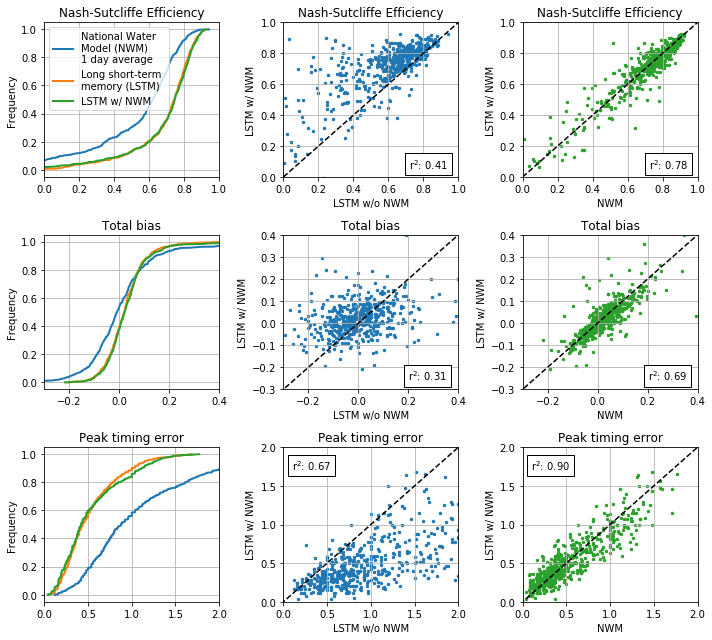

In [49]:
met_lims = [[0,1], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [-.3,.4],[-50,50], [],[],[],[0,2]]
text_loc = [0.75,0.05]
place_text = [[[0.72,0.05], [0.72,0.05]], [[.2,-.26],[.2,-.26]], [[.1,1.7], [.1,1.7]]]
yvalues = list(range(len(basin_list)))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)
    
plot_model_names_long = ['National Water \nModel (NWM) \n1 day average',
                         'Long short-term \nmemory (LSTM)', 
                         'LSTM w/ NWM']    

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(3,3, figsize=(10,9))

for imet, nmet in enumerate([0,6,11]):
    met_name = mets[imet]
    x_lim_imet = met_lims[imet]
    x = [np.array(ensemble_metric_dictionary['nwm'][:,nmet]),
         np.array(ensemble_metric_dictionary['v0'][:,nmet]),
         np.array(ensemble_metric_dictionary['v2'][:,nmet])]
    for imod,X in enumerate(x):
        plotdata = X
        plotdata = np.sort(plotdata[~pd.isnull(plotdata)])
        axes[imet,0].plot(plotdata,  yvalues[:len(plotdata)], label=plot_model_names_long[imod], lw=2)
        axes[imet,0].grid()
        axes[imet,0].set_xlim(list(met_lims[nmet]))
        axes[imet,0].set_title(metric_names[imet])
        axes[imet,0].set_ylabel('Frequency')

    ydata = x[1]
    xdata = x[0]
    axes[imet,1].plot(list(met_lims[imet]), list(met_lims[imet]), 'k--')
    axes[imet,1].scatter(xdata,  ydata, label=plot_model_names[imod], marker='o', s=6, c=cycle[0])
    axes[imet,1].grid()
    axes[imet,1].set_xlim(list(met_lims[nmet]))
    axes[imet,1].set_ylim(list(met_lims[nmet]))
#     mmiinn = np.min(np.minimum(xdata, ydata))
#     mmaaxx = np.max(np.maximum(xdata, ydata))
#     axes[imet,1].set_xlim([mmiinn, mmaaxx])
#     axes[imet,1].set_ylim([mmiinn, mmaaxx])
    axes[imet,1].set_title(metric_names[imet])
    axes[imet,1].set_ylabel('LSTM w/ NWM')
    axes[imet,1].set_xlabel('LSTM w/o NWM')
    corr = 'r$^2$: {:.2f}'.format(st.stats.pearsonr(xdata, ydata)[0])
    t_1 = axes[imet,1].text(place_text[imet][0][0],place_text[imet][0][1],corr)
    t_1.set_bbox(dict(facecolor='white', alpha=1))

    ydata = x[1]
    xdata = x[2]
    axes[imet,2].plot(list(met_lims[imet]), list(met_lims[imet]), 'k--')
    axes[imet,2].scatter(xdata,  ydata, label=plot_model_names[imod], marker='o', s=6, c=cycle[2])
    axes[imet,2].grid()
    axes[imet,2].set_xlim(list(met_lims[nmet]))
    axes[imet,2].set_ylim(list(met_lims[nmet]))
#     mmiinn = np.min(np.minimum(xdata, ydata))
#     mmaaxx = np.max(np.maximum(xdata, ydata))
#     axes[imet,2].set_xlim([mmiinn, mmaaxx])
#     axes[imet,2].set_ylim([mmiinn, mmaaxx])
    axes[imet,2].set_title(metric_names[imet])
    axes[imet,2].set_ylabel('LSTM w/ NWM')
    axes[imet,2].set_xlabel('NWM')
    corr = 'r$^2$: {:.2f}'.format(st.stats.pearsonr(xdata, ydata)[0])
    t_2 = axes[imet,2].text(place_text[imet][1][0],place_text[imet][1][1],corr)
    t_2.set_bbox(dict(facecolor='white', alpha=1))
    
axes[0,0].legend()
fig.tight_layout() 

# Plot the change in performance on a map

In [58]:
plot_lats = []
plot_lons = []
for i, b in enumerate(basin_list):
    plot_lats.append(attributes.loc[int(b),'gauge_lat'])
    plot_lons.append(attributes.loc[int(b),'gauge_lon'])
plot_lats = np.array(plot_lats)
plot_lons = np.array(plot_lons)

In [59]:
# spatial plot of improvements
bounds = [(-0,1), (-0.2,0.1), (0,2)]
diff_bounds = [1, 0.2, 2]
optimal = [1, 0, 0]
display_colors_from_control = {'nwm':'PRGn', 'v0':'PRGn'} #Alternative color scheme: 'PuOr'
display_bounds_from_control = {'nwm':[(-0,1), (-0.2,0.1), (0,2)], 'v0':[(-0,1), (-0.2,0.1), (0,2)]}

In [60]:
def PERFORMANCE_IMPROVEMENTS(control, test, percent=False):
    improvement = np.full([len(basin_list),len(use_metrics)], np.nan)
    percent_improvement = np.full([len(basin_list),len(use_metrics)], np.nan)
    for m, metric in enumerate(use_metrics):
        imet=use_metric_locs[m]
        if optimal[m] == 1:
            improvement[:,m] = ensemble_metric_dictionary[test][:,imet] - \
                               ensemble_metric_dictionary[control][:,imet]
            percent_improvement[:,m] = improvement[:,m] / np.abs(ensemble_metric_dictionary[control][:,imet])
        elif optimal[m] == 0:
            improvement[:,m] = np.abs(ensemble_metric_dictionary[control][:,imet]) - \
                                np.abs(ensemble_metric_dictionary[test][:,imet])
            percent_improvement[:,m] = improvement[:,m] / np.abs(ensemble_metric_dictionary[control][:,imet])
    if percent:
        return percent_improvement
    else:
        return improvement

In [61]:
# Correlation grid
control='v0'
test='v2'
for imet, nmet in enumerate(use_metric_locs):
    print(use_metrics[imet])
    corrs = pd.DataFrame(index=model_type_list_for_corr, columns=model_type_list_for_corr)
    for i, imod in enumerate(model_name_list_for_corr):
        for j, jmod in enumerate(model_name_list_for_corr):
            corrs.iloc[i,j] = CALCULATE_CORRELATION(imod, jmod, use_metrics=[nmet])[0]
    print(corrs)

NSE
                  NWM      LSTM LSTM w/ NWM LSTM+NWMx
NWM                 1  0.406531    0.710596   0.66893
LSTM         0.406531         1    0.782916  0.731586
LSTM w/ NWM  0.710596  0.782916           1   0.95683
LSTM+NWMx     0.66893  0.731586     0.95683         1
Beta-NSE
                  NWM      LSTM LSTM w/ NWM LSTM+NWMx
NWM                 1  0.308931     0.63722  0.611941
LSTM         0.308931         1    0.689246  0.659544
LSTM w/ NWM   0.63722  0.689246           1  0.969833
LSTM+NWMx    0.611941  0.659544    0.969833         1
Peak-Timing
                  NWM      LSTM LSTM w/ NWM LSTM+NWMx
NWM                 1  0.670197     0.75432  0.762158
LSTM         0.670197         1    0.897774  0.870376
LSTM w/ NWM   0.75432  0.897774           1  0.917457
LSTM+NWMx    0.762158  0.870376    0.917457         1


In [62]:
use_metrics

['NSE', 'Beta-NSE', 'Peak-Timing']

In [63]:
def COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, threshold=1, verbose=True):
    for m, metric in enumerate(use_metrics):
        count_improved = 0
        count_detriment = 0
        count_total = 0
        imet=use_metric_locs[m]
        for i, ival in enumerate(improvement[:,m]):
            if ensemble_metric_dictionary['nwm'][i,0] < threshold:
                count_total += 1
                if ival > 0:
                    count_improved+= 1
                if ival < 0:
                    count_detriment+= 1
        if verbose:
            print(metric)
            print('Number of improved basins = {}, {:.2f}%'.format(count_improved, 
                                                                   count_improved/count_total))
            print('Number of detrimented basins = {}, {:.2f}%'.format(count_detriment, 
                                                                      count_detriment/count_total))
        else:
            if metric == 'NSE':
                return count_improved/count_total

In [64]:
def PLOT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, percent=False):
    
    bound = display_bounds_from_control[control]
    
    fig = plt.figure(figsize=(10, 9))
    gs = fig.add_gridspec(len(use_metrics),3)

    for m, metric in enumerate(use_metrics):

        imet=use_metric_locs[m]

        ax0 = fig.add_subplot(gs[m,:2])
        im = ax0.scatter(plot_lons, plot_lats,
                        c=improvement[:,m],
                        s=20,
                        cmap=display_colors_from_control[control],
                        vmin=-diff_bounds[m], vmax=diff_bounds[m])
        ax0.set_title(use_metric_names[m])
        clims = im.get_clim()

        # colorbar
        divider = make_axes_locatable(ax0)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax1 = fig.add_subplot(gs[m,2])    
        ax1.plot(bounds[m], bounds[m], 'k--', lw=0.6)
        for b, basin in enumerate(basin_list):
            basin_color = im.to_rgba(improvement[b,m])
            ax1.scatter(ensemble_metric_dictionary[control][b,imet], 
                        ensemble_metric_dictionary[test][b,imet],
                        s=5,
                        color=im.to_rgba(improvement[b,m]))
        ax1.set_xlabel(display_model_names[control])
        ax1.set_ylabel(display_model_names[test])
        ax1.set_xlim(bounds[m])
        ax1.set_ylim(bounds[m])
        ax1.grid()

    plt.tight_layout()

NSE
Number of improved basins = 488, 0.92%
Number of detrimented basins = 43, 0.08%
Beta-NSE
Number of improved basins = 331, 0.62%
Number of detrimented basins = 200, 0.38%
Peak-Timing
Number of improved basins = 494, 0.93%
Number of detrimented basins = 25, 0.05%


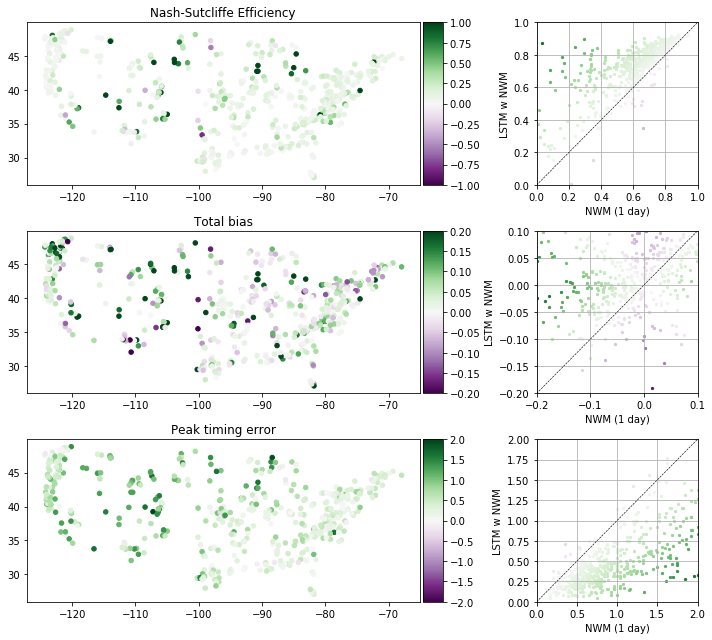

In [65]:
control='nwm'
test='v2'
improvement = PERFORMANCE_IMPROVEMENTS(control, test, percent=False)
PLOT_PERFORMANCE_IMPROVEMENTS(improvement, control, test)
COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, verbose=True)

NSE
Number of improved basins = 291, 0.55%
Number of detrimented basins = 240, 0.45%
Beta-NSE
Number of improved basins = 258, 0.49%
Number of detrimented basins = 273, 0.51%
Peak-Timing
Number of improved basins = 228, 0.43%
Number of detrimented basins = 223, 0.42%


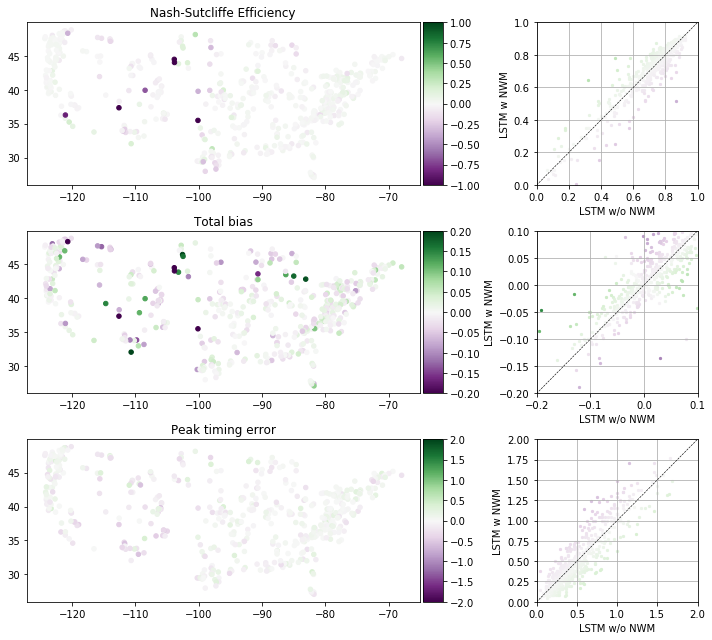

In [66]:
control='v0'
test='v2'
improvement = PERFORMANCE_IMPROVEMENTS(control, test, percent=False)
PLOT_PERFORMANCE_IMPROVEMENTS(improvement, control, test)
COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, verbose=True)

# Performance metrics for the NWM and the LSTM, LSTM Post Processor

In [35]:
# Get the days of the record that correspond to each flow type, for each basin.

if calculate_flow_categories:
    flow_dates = {fc:{b:[] for b in basin_list} for fc in flow_categories}

    for ib, b in enumerate(basin_list):  
        df = lstm_sample[b]

        for i_date, today in enumerate(date_range):
            # For a baseline also evaluate the whole record
            flow_dates['all'][b].append(today)

            # Rising and falling limbs
            if i_date>0:
                yesterday =  date_range[i_date-1]
                diff_1d = df.loc[today,'qobs']-df.loc[yesterday,'qobs']
                if diff_1d < 0:
                    flow_dates['fall'][b].append(today)
                if diff_1d > 0:
                    flow_dates['rise'][b].append(today)

            # Above or below Median
            if df.loc[today,'qobs'] > np.median(df.loc[:,'qobs']):
                flow_dates['above_mid'][b].append(today)
            else:
                flow_dates['below_mid'][b].append(today)

            # Above or below Mean
            if df.loc[today,'qobs'] > np.mean(df.loc[:,'qobs']):
                flow_dates['above_mean'][b].append(today)
            else:
                flow_dates['below_mean'][b].append(today)

            # Above or below 20th/80th percentile
            if df.loc[today,'qobs'] > np.percentile(df.loc[:,'qobs'], 80):
                flow_dates['above_80'][b].append(today)
            elif df.loc[today,'qobs'] < np.percentile(df.loc[:,'qobs'], 20):
                flow_dates['below_20'][b].append(today) 
        # Save values to pickle file
        with open(data_dir+'flow_category_dates.p','wb') as f:
            pkl.dump(flow_dates, f)
else:
    with open(data_dir+'flow_category_dates.p','rb') as f:
        flow_dates = pkl.load(f)

In [36]:
def calc_nse(obs, sim):
    diff1 = obs - sim
    diff2 = obs - np.mean(obs)
    numer = np.nanmean(np.power(diff1,2))
    denom = np.nanmean(np.power(diff2,2))
    return 1-numer/denom
def calc_bias(obs, sim):
    sum_obs = np.sum(obs)
    sum_sim = np.sum(sim)
    return sum_obs - sum_sim
def calc_beta_nse(obs, sim):
    return float((sim.mean() - obs.mean()) / obs.std())
def calc_alpha_nse(obs, sim):
    return float(sim.std() / obs.std())

In [37]:
# Get all the metrics available in one list.

if calculate_metric_matrix:

    met_mat = {fc:np.full([nbasins,3,nmets],np.nan) for fc in flow_categories}

    flow_mat = {fc:{mt:[] for mt in obs_model_types} for fc in flow_categories}

    did_not_calculate = []

    # Loop through the basins and calculate the performance metric.
    for ib, b in enumerate(basin_list):  
        # Keep a record of any infinities that come out of performance metric calculations.
        basin_inf = {fc:[] for fc in ['nwm', 'v0', 'v2']}

        # Loop through the flow categories, and calculate the performance metrics.
        # Any flow category that is split up by percentile 
        for fc in flow_categories:
            # But some of the metrics do not make sense when the flow is split up by category
            #             i.e., the timing metrics don't make sense without consecutive days.
            if fc != flow_categories[0]:
                loop_mets = mets[0:7]
            else:
                loop_mets = mets

            flow_set = flow_dates[fc][b]

            xobs = xr.DataArray(lstm_sample[b].loc[flow_set, 'qobs']).rename({'dim_0': 'date'})
            flow_mat[fc]['obs'].extend(list(lstm_sample[b].loc[flow_set,'qobs']))

            # Do not calculate the metrics on the basins that have a mean close to zero.
            # This will lead to -inf or very low (-100xxx) Nash-Sutcliffe values.
            if np.mean(lstm_sample[b].loc[flow_set, 'qobs']) > 0:
                is_calc_metrics = True
            else:
                is_calc_metrics = False
                did_not_calculate.append([b,fc])

            # 1) combined flows from all basins into one dictionary, for overall metrics
            # 2) Calculate the metrics for each model type.
            for imt, model_type in enumerate(['nwm', 'v0','v2']):
                # Combine all the basins so the metrics can be calculated across them all at once.
                flow_mat[fc][model_type].extend(list(ensemble_q_dictionary[model_type][b].loc[flow_set]))
                # Now just put the curent basin's flow into an xarray to get the metrics for this basin alone.
                xsim = xr.DataArray(ensemble_q_dictionary[model_type][b].loc[flow_set]).rename({'dim_0': 'date'})
                if is_calc_metrics:
                    met_dict = metrics.calculate_metrics(xobs, xsim, loop_mets)
                    for imet, met_name in enumerate(loop_mets):
                        if np.isinf(met_dict[met_name]):
                                basin_inf[model_type].append([b, met_name])
                        met_mat[fc][ib,imt,imet] = met_dict[met_name]
                        
    with open(data_dir+'metrics_matrix_v2.p','wb') as f:
            pkl.dump(met_mat, f)
    with open(data_dir+'flow_regime_matrix.p','wb') as f:
            pkl.dump(flow_mat, f)
else:
    with open(data_dir+'metrics_matrix_v2.p','rb') as f:
        met_mat = pkl.load(f)
    with open(data_dir+'flow_regime_matrix.p','rb') as f:
        flow_mat = pkl.load(f)

In [38]:
model_types = ['nwm', 'v0', 'v2']
model_types2 = ['NWM', 'LSTM', 'LSTM+NWM']
combined_metric_list = ['nse', 'variance', 'bias', 'pearsonr']
combined_metric_results={fr:pd.DataFrame(index=model_types2, columns=combined_metric_list) 
                         for fr in flow_categories}
for fc in flow_categories:
    for imodel, model_name in enumerate(model_types):
        obs = np.array(flow_mat[fc]['obs'])
        sim = np.array(flow_mat[fc][model_name])
        combined_metric_results[fc].loc[model_types2[imodel],'nse']=calc_nse(obs,sim)
        combined_metric_results[fc].loc[model_types2[imodel],'bias']=calc_beta_nse(obs,sim)
        combined_metric_results[fc].loc[model_types2[imodel],'variance']=calc_alpha_nse(obs,sim)
        combined_metric_results[fc].loc[model_types2[imodel],'pearsonr'], _ = st.pearsonr(obs,sim)
combined_metric_results

{'all':                nse  variance        bias  pearsonr
 NWM       0.751816  0.846744  -0.0184721  0.867519
 LSTM      0.817737   0.88938  0.00984948  0.904467
 LSTM+NWM  0.824265  0.925918   0.0156675  0.908199,
 'rise':                nse  variance         bias  pearsonr
 NWM       0.726028  0.819173   -0.0548034  0.854566
 LSTM      0.781106   0.84524  -0.00919622  0.884731
 LSTM+NWM  0.791306  0.893214 -0.000253691  0.889561,
 'fall':                nse  variance        bias  pearsonr
 NWM        0.77958  0.895809  0.00471951  0.883043
 LSTM      0.869848  0.960402    0.025252  0.933389
 LSTM+NWM  0.870366  0.978455   0.0301859  0.934459,
 'above_mean':                nse  variance       bias  pearsonr
 NWM        0.69371  0.834777 -0.0899963  0.837746
 LSTM      0.775766  0.866546 -0.0449921  0.882061
 LSTM+NWM  0.783924  0.908811 -0.0292369  0.886167,
 'below_mean':                nse variance      bias  pearsonr
 NWM       0.581192   1.1337  0.117637  0.829279
 LSTM      0.67

In [39]:
mets

['NSE',
 'MSE',
 'RMSE',
 'KGE',
 'Alpha-NSE',
 'Pearson r',
 'Beta-NSE',
 'FHV',
 'FMS',
 'FLV',
 'MAPTE',
 'Peak-Timing']

In [40]:
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('expand_frame_repr', False)
for fc in flow_categories:
    print(fc)
    G = [np.nanmean(met_mat[fc][:,0,0]), 
         np.nanmean(met_mat[fc][:,1,0]), 
         np.nanmean(met_mat[fc][:,2,0])]
    H = [np.nanmedian(met_mat[fc][:,0,0]), 
         np.nanmedian(met_mat[fc][:,1,0]), 
         np.nanmedian(met_mat[fc][:,2,0])]
    I = [np.nanmedian(met_mat[fc][:,0,3]), 
         np.nanmedian(met_mat[fc][:,1,3]), 
         np.nanmedian(met_mat[fc][:,2,3])]
    J = [np.nanmedian(met_mat[fc][:,0,4]), 
         np.nanmedian(met_mat[fc][:,1,4]), 
         np.nanmedian(met_mat[fc][:,2,4])]
    K = [np.nanmedian(met_mat[fc][:,0,6]), 
         np.nanmedian(met_mat[fc][:,1,6]), 
         np.nanmedian(met_mat[fc][:,2,6])]
    L = [np.nanmedian(met_mat[fc][:,0,5]), 
         np.nanmedian(met_mat[fc][:,1,5]), 
         np.nanmedian(met_mat[fc][:,2,5])]
    M = [np.nanmedian(met_mat[fc][:,0,11]), 
         np.nanmedian(met_mat[fc][:,1,11]), 
         np.nanmedian(met_mat[fc][:,2,11])]
    df = pd.DataFrame(data=np.array([G, H, I, J, K, L]).reshape(6,3).transpose(),
                      index=['NWM', 'LSTM', 'LSTM+NWM'],  
            columns=['NSE(mean)','NSE(median)','KGE','Alpha-NSE','Beta-NSE','Pearsonr'])
    print(df)

all
          NSE(mean)  NSE(median)     KGE  Alpha-NSE  Beta-NSE  Pearsonr
NWM         0.45578      0.62108 0.64431    0.82388  -0.00928   0.81508
LSTM        0.68767      0.74258 0.73979    0.83477   0.02058   0.87725
LSTM+NWM    0.64910      0.72331 0.72402    0.83650   0.02223   0.86931
rise
          NSE(mean)  NSE(median)     KGE  Alpha-NSE  Beta-NSE  Pearsonr
NWM         0.47008      0.60100 0.59946    0.77427  -0.06680   0.81274
LSTM        0.66240      0.71157 0.71971    0.80473  -0.00906   0.86278
LSTM+NWM    0.62904      0.69796 0.68324    0.78928  -0.01220   0.85493
fall
          NSE(mean)  NSE(median)     KGE  Alpha-NSE  Beta-NSE  Pearsonr
NWM         0.27651      0.60485 0.63987    0.94178   0.04072   0.82902
LSTM        0.69215      0.78057 0.77200    0.91716   0.04551   0.90289
LSTM+NWM    0.63809      0.76477 0.75066    0.92791   0.05619   0.89735
above_mean
          NSE(mean)  NSE(median)     KGE  Alpha-NSE  Beta-NSE  Pearsonr
NWM         0.21416      0.44541 0.5744

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [41]:
def calc_wilcoxon(fc, column):
    stat0, p0 = st.wilcoxon(met_mat[fc][:,0,column], met_mat[fc][:,2,column])
    stat2, p2 = st.wilcoxon(met_mat[fc][:,1,column], met_mat[fc][:,2,column])
    return [p0,p2]    

pd.options.display.float_format = '{:.5f}'.format
pd.set_option('expand_frame_repr', False)
for fc in flow_categories:
    print(fc)
    H = calc_wilcoxon(fc, 0)   
    I = calc_wilcoxon(fc, 3)
    J = calc_wilcoxon(fc, 4)
    K = calc_wilcoxon(fc, 6)
    L = calc_wilcoxon(fc, 5)
    M = calc_wilcoxon(fc, 11)
    df = pd.DataFrame(data=np.array([H, I, J, K, L, M]).reshape(6,2).transpose(),
                      index=['NWM', 'LSTM'],  
            columns=['NSE','KGE','Alpha-NSE','Beta-NSE','Pearsonr','PeakTiming'])
    print(df)

all
         NSE     KGE  Alpha-NSE  Beta-NSE  Pearsonr  PeakTiming
NWM  0.00000 0.00000    0.21146   0.00000   0.00000     0.00000
LSTM 0.00000 0.00000    0.21032   0.00007   0.00000     0.00007
rise
         NSE     KGE  Alpha-NSE  Beta-NSE  Pearsonr  PeakTiming
NWM  0.00000 0.00000    0.88714   0.00000   0.00000     0.00000
LSTM 0.00000 0.00000    0.01066   0.04214   0.00000     0.00000
fall
         NSE     KGE  Alpha-NSE  Beta-NSE  Pearsonr  PeakTiming
NWM  0.00000 0.00000    0.00023   0.51063   0.00000     0.00000
LSTM 0.00000 0.00000    0.00011   0.00000   0.00000     0.00000
above_mean
         NSE     KGE  Alpha-NSE  Beta-NSE  Pearsonr  PeakTiming
NWM  0.00000 0.00000    0.00837   0.00017   0.00000     0.00000
LSTM 0.00000 0.00000    0.33446   0.55803   0.00000     0.00000
below_mean
         NSE     KGE  Alpha-NSE  Beta-NSE  Pearsonr  PeakTiming
NWM  0.00000 0.00000    0.00000   0.00000   0.00000     0.00000
LSTM 0.00000 0.00000    0.64635   0.00000   0.00000     0.00000
abov

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2882: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2883: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


# Calculate the hydrologic signatures for all the models and oberservation

In [42]:
# Calculate the hydrologic signatures for all the models, and see which is closer to the observation.
sigs = signatures.get_available_signatures()
nsigs = len(sigs)
sigs_dict = {imod:pd.DataFrame(index=basin_list, data=np.full([nbasins,nsigs],np.nan), columns=sigs) \
             for imod in obs_model_types}

for root, subdirs, files in os.walk(nldas_dir):
    for file in files:
        file_path = os.path.join(root, file)
        b = file[0:8]
        if b not in flow_dates['all'].keys():
            continue
        flow_set = flow_dates['all'][b]
        hu = attributes.loc[int(b), 'basin_hydro_unit']
        with open(file_path, 'r') as f:
            df = pd.read_csv(f, sep="\s+",header=3)
        dti = pd.date_range('1980-01-01', periods=df.shape[0], freq='D')
        df['date'] = dti
        df = df.set_index('date')
        prcp=xr.DataArray(df['PRCP(mm/day)'])

        for imt, model_type in enumerate(['nwm', 'v0','v2']):
            xsim = xr.DataArray(ensemble_q_dictionary[model_type][b].loc[flow_set]).rename({'dim_0': 'date'})
            sigs_dict[model_type].loc[b,:] = signatures.calculate_all_signatures(da=xsim, prcp=prcp)
            
        xobs = xr.DataArray(lstm_sample[b].loc[flow_set, 'qobs']).rename({'dim_0': 'date'})
        sigs_dict['obs'].loc[b,:] = signatures.calculate_all_signatures(da=xobs, prcp=prcp)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


high_q_freq


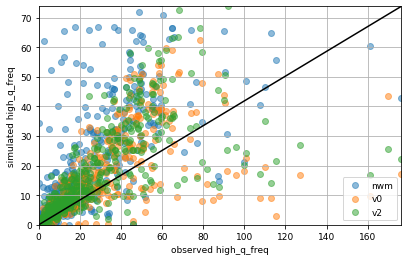

high_q_dur


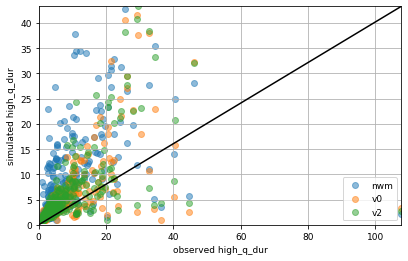

low_q_freq


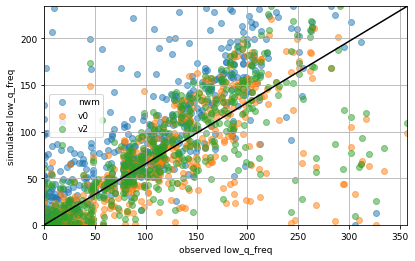

low_q_dur


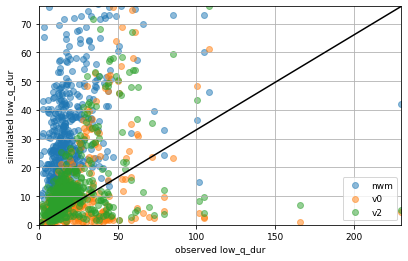

zero_q_freq


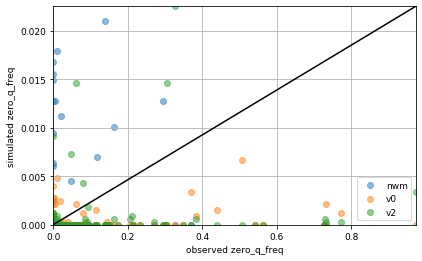

q95


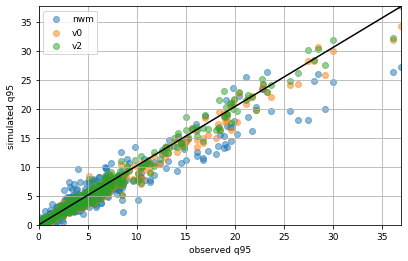

q5


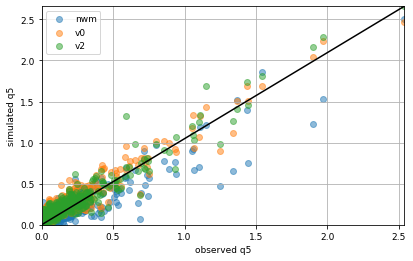

q_mean


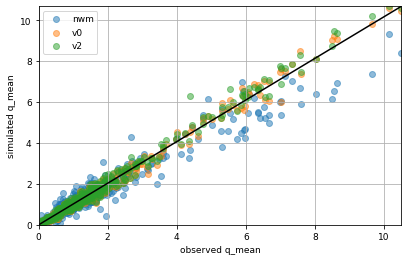

hfd_mean


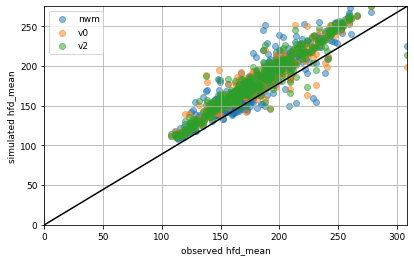

baseflow_index


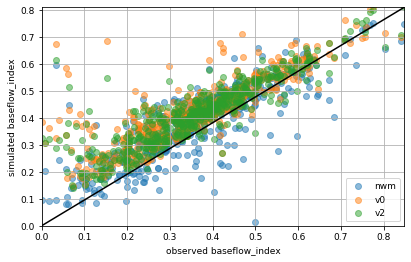

slope_fdc


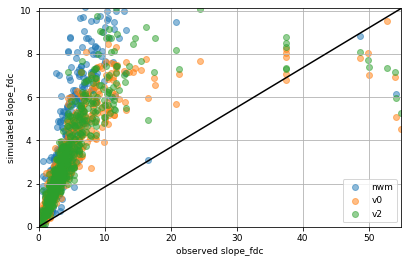

stream_elas


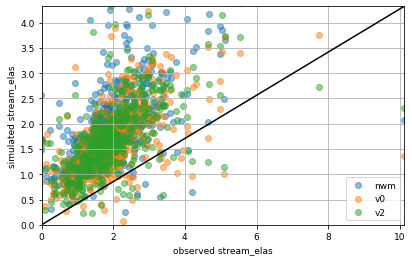

runoff_ratio


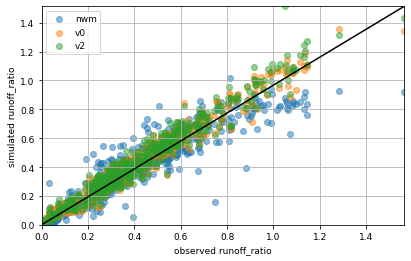

In [43]:
#RMSE Values
model_types2 = ["NWM", "LSTM", "LSTM+NWM"]
count_zero_q_freq = {"obs":0, "NWM":0, "LSTM":0, "LSTM+NWM":0}

df_sigs={'rmse':pd.DataFrame(index=sigs_dict['obs'].columns.values, columns=model_types2),
         'r-squared':pd.DataFrame(index=sigs_dict['obs'].columns.values, columns=model_types2)}

df_sigs_signif = pd.DataFrame(index=sigs_dict['obs'].columns.values, columns=["NWM", "LSTM", "n"])

for sig in sigs_dict['obs'].columns.values:
    print(sig)
    if sig=="zero_q_freq":
        df_temp = sigs_dict['obs'].loc[:,sig]
        count_zero_q_freq["obs"] = df_temp[df_temp > 0].count() 
        
    for imod, imod2 in zip(model_types, model_types2):
        df_sigs['rmse'].loc[sig,imod2] = np.log(np.sqrt(np.square(np.mean(sigs_dict['obs'].loc[:,sig] - 
                                         sigs_dict[imod].loc[:,sig]))))
        if sig=="zero_q_freq":
            df_temp = sigs_dict[imod].loc[:,sig]
            count_zero_q_freq[imod2] = df_temp[df_temp > 0].count() 
            

    mpl.rcParams.update({'font.size': 9})
    fig, ax = plt.subplots(figsize=(6.5,4.02))
    
    for imod, imod2 in zip(model_types, model_types2):
        obs_1d = np.array(sigs_dict['obs'].loc[:,sig]).reshape(sigs_dict['obs'].loc[:,sig].shape[0],)
        sigs_1d = np.array(sigs_dict[imod].loc[:,sig]).reshape(sigs_dict[imod].loc[:,sig].shape[0],)
        df = pd.DataFrame({'obs':obs_1d, 'sig':sigs_1d})
        df = df.dropna()
        slope, intercept, r_value, p_value, std_err = st.linregress(df['obs'], df['sig'])

        df_sigs['r-squared'].loc[sig,imod2] = r_value**2
        
        #Calculates the statistic significance between two dependent correlation coefficients
        if imod == 'v2':
            df_nanfree = pd.DataFrame({'obs':sigs_dict['obs'].loc[:,sig],
                                       'nwm':sigs_dict['nwm'].loc[:,sig],
                                       'v0':sigs_dict['v0'].loc[:,sig],
                                       'v2':sigs_dict['v2'].loc[:,sig]})
            df_nanfree = df_nanfree.replace([np.inf, -np.inf], np.nan)
            df_nanfree = df_nanfree.dropna()
            
            xy = st.pearsonr(df_nanfree['nwm'], df_nanfree['obs'])[0]
            xz = st.pearsonr(df_nanfree['v2'], df_nanfree['obs'])[0]
            yz = st.pearsonr(df_nanfree['nwm'], df_nanfree['v2'])[0]
            _, df_sigs_signif.loc[sig,'NWM'] = corrstats.independent_corr(xy, xz, df_nanfree.shape[0])
#            _, df_sigs_signif.loc[sig,'NWM'] = corrstats.dependent_corr(xy, xz, yz, df_nanfree.shape[0])
            
            xy = st.pearsonr(df_nanfree['v0'], df_nanfree['obs'])[0]
            xz = st.pearsonr(df_nanfree['v2'], df_nanfree['obs'])[0]
            yz = st.pearsonr(df_nanfree['v0'], df_nanfree['v2'])[0]
            _, df_sigs_signif.loc[sig,'LSTM'] = corrstats.independent_corr(xy, xz, df_nanfree.shape[0])
#            _, df_sigs_signif.loc[sig,'LSTM'] = corrstats.dependent_corr(xy, xz, yz, df_nanfree.shape[0])
            
            df_sigs_signif.loc[sig,'n'] = df_nanfree.shape[0]
        
        ax.scatter(sigs_dict['obs'].loc[:,sig], sigs_dict[imod].loc[:,sig], alpha=.5, label=imod)
        plt.grid()
    
    plt.ylabel('simulated '+sig,fontname="Arial")
    plt.xlabel('observed '+sig,fontname="Arial")
    plt.plot([0,np.max(sigs_dict['obs'].loc[:,sig])],
             [0,np.max(sigs_dict[imod].loc[:,sig])], c='k')
    plt.xlim([0,np.max(sigs_dict['obs'].loc[:,sig])])
    plt.ylim([0,np.max(sigs_dict[imod].loc[:,sig])])
    plt.legend()
    plt.show()
    plt.close()

In [44]:
count_zero_q_freq

{'obs': 101, 'NWM': 56, 'LSTM': 35, 'LSTM+NWM': 29}

In [45]:
df_sigs_signif

,NWM,LSTM,n
high_q_freq,0.83510,0.40455,531
high_q_dur,0.05675,0.94346,512
low_q_freq,0.96250,0.07798,531
low_q_dur,0.70667,0.37240,471
zero_q_freq,0.00000,0.31009,531
q95,0.00000,0.83996,531
q5,0.00000,0.98227,531
q_mean,0.00000,0.89308,531
hfd_mean,0.00000,0.30991,531
baseflow_index,0.02392,0.00897,531


In [46]:
sig='zero_q_freq'
df_nanfree = pd.DataFrame({'nwm':sigs_dict['nwm'].loc[:,sig],
                           'v0':sigs_dict['v0'].loc[:,sig],
                           'v2':sigs_dict['v2'].loc[:,sig]})
df_nanfree = df_nanfree.replace([np.inf, -np.inf], np.nan)
df_nanfree = df_nanfree.dropna()
count_above_zero = {'nwm':0, 'v0':0, 'v2':0}
for i in df_nanfree.iterrows():
    for mod in ['nwm', 'v0', 'v2']:
        if i[1][mod] > 0:
            count_above_zero[mod] += 1
count_above_zero

{'nwm': 56, 'v0': 35, 'v2': 29}

In [47]:
df_sigs['r-squared'].sort_values('NWM').loc[:, ['NWM', 'LSTM', 'LSTM+NWM']]

,NWM,LSTM,LSTM+NWM
low_q_dur,0.15513,0.10477,0.14883
zero_q_freq,0.22290,0.07370,0.04524
high_q_dur,0.24083,0.38291,0.38572
stream_elas,0.28631,0.30852,0.32754
high_q_freq,0.50720,0.46121,0.49816
slope_fdc,0.51700,0.43846,0.43037
low_q_freq,0.60266,0.53012,0.60087
baseflow_index,0.71109,0.70029,0.77264
runoff_ratio,0.82128,0.95552,0.95251
hfd_mean,0.84783,0.90518,0.91584


In [48]:
for row in df_sigs['r-squared'].sort_values('NWM').loc[:, ['NWM', 'LSTM', 'LSTM+NWM']].iterrows():
    nwm_improvement = (row[1]['LSTM+NWM'] - row[1]['NWM'])/row[1]['NWM']
    lstm_improvement = (row[1]['LSTM+NWM'] - row[1]['LSTM'])/row[1]['LSTM']
    print('{}: {:.0%}, {:.0%}'.format(row[0], nwm_improvement, lstm_improvement))

low_q_dur: -4%, 42%
zero_q_freq: -80%, -39%
high_q_dur: 60%, 1%
stream_elas: 14%, 6%
high_q_freq: -2%, 8%
slope_fdc: -17%, -2%
low_q_freq: -0%, 13%
baseflow_index: 9%, 10%
runoff_ratio: 16%, -0%
hfd_mean: 8%, 1%
q5: 8%, -0%
q95: 8%, -0%
q_mean: 5%, -0%


In [49]:
df_sigs['r-squared'].sort_values('NWM').loc[:, ['NWM', 'LSTM', 'LSTM+NWM']].mean()

NWM        0.58603
LSTM       0.59649
LSTM+NWM   0.61312
dtype: float64

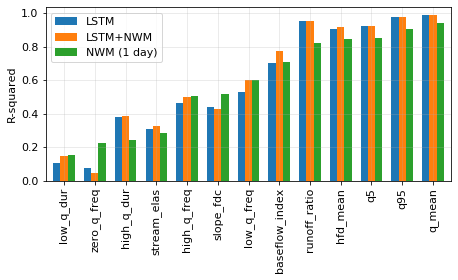

In [78]:
fig_scale=1
mpl.rcParams.update({'font.size': 11})
#fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=False, figsize=(fig_scale*6.5, fig_scale*4.02))
fig, ax0 = plt.subplots(figsize=(fig_scale*6.5, fig_scale*4.02))

df_plot = df_sigs['r-squared'].sort_values('NWM').loc[:, ['LSTM', 'LSTM+NWM', 'NWM']]

df_plot.plot.bar(ax=ax0, width=.7)

ax0.set_ylabel('R-squared')
ax0.grid(alpha=0.3)
ax0.legend(plot_model_names)
# df_sigs['rmse'].sort_values('NWM').loc[:, ['NWM', 'LSTM', 'LSTM+NWM']].plot.bar(ax=ax1)
# ax1.set_ylabel('log of RMSE')
# ax1.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

# POST PROCESSOR PERFORMANCE REGRESSION

In [51]:
attributes['nwm'] = [np.nan]*attributes.shape[0]
attributes['v0'] = [np.nan]*attributes.shape[0]
attributes['v2'] = [np.nan]*attributes.shape[0]
attributes['lstmnwm-nwm'] = [np.nan]*attributes.shape[0]
imet=0
r=0
for i, b in enumerate(basin_list):
    attributes.loc[int(b), 'v0'] = ensemble_metric_dictionary['v0'][i,imet]
    attributes.loc[int(b), 'v2'] = ensemble_metric_dictionary['v2'][i,imet]
    attributes.loc[int(b), 'nwm'] = ensemble_metric_dictionary['nwm'][i,imet]
    attributes.loc[int(b), 'lstmnwm-nwm'] = ensemble_metric_dictionary['v2'][i,imet] - \
                       ensemble_metric_dictionary['nwm'][i,imet]
# Remove any rows with nan
df = attributes.dropna()

In [52]:
# 528 basins / 16 splits = 33 samples in each split.
n_splits = 16 

In [53]:
# Python program to sort  
# one list using 
# the other list 
def sort_list(list1, list2): 
    zipped_pairs = zip(list2, list1) 
    z = [x for _, x in sorted(zipped_pairs)] 
    return z

In [54]:
def print_stats(d):
    print("mean = {:.2f},  median = {:.2f}, stdev = {:.2f}, min = {:.2f}, max = {:.2f}".format(
        np.nanmean(np.array(d)),
        np.nanmedian(np.array(d)),
        np.nanstd(np.array(d)),
        np.nanmin(np.array(d)),
        np.nanmax(np.array(d))
        )
    )

In [55]:
# Random Forest Regression in a K-fold loop
def cross_val_rf(X,y,feature_list,kf,ynormal=False,
                 n_estimators=10,random_state=42,
                 criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                 min_weight_fraction_leaf=0, feature_list_short=[]):

    if len(feature_list_short) > 1:
        index_labs = feature_list_short
    else:
        index_labs = feature_list
    feature_importances = pd.DataFrame(index=index_labs, columns=['total_importance'])
    for iF, F in enumerate(feature_importances.index.values):
        feature_importances.loc[F, 'total_importance'] = 0
    
    rmse_list = []
    r2_list = []
    y_hat_list = []
    y_hat_indx_list = []
    
    fig, ax = plt.subplots(figsize=(6.5,4.02))
    grid = plt.GridSpec(1, 3, wspace=0.33333)
    plt.subplot(grid[0, 0:2])
    for train_index, test_index in kf.split(X):
                
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                  criterion=criterion, min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, max_depth=max_depth,
                                  min_weight_fraction_leaf=min_weight_fraction_leaf)
        rf.fit(X_train, y_train);
        y_hat = rf.predict(X_test)

        # Get numerical feature importances
        importances = list(rf.feature_importances_)
        for iF, F in enumerate(feature_importances.index.values):
            feature_importances.loc[F, 'total_importance'] += importances[iF]
        
        rmse = np.sqrt(np.mean(np.power((y_test - y_hat),2)))
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, y_hat)
        r2 = r_value**2        
        plt.scatter(y_test,y_hat)
        
        rmse_list.append(rmse)
        r2_list.append(r2)
        y_hat_list.extend(y_hat)
        y_hat_indx_list.extend(test_index)
    
    feature_importances.loc[:, 'total_importance'] = feature_importances.loc[:, 'total_importance'] / \
                                                     kf.get_n_splits()

    #plt.title("Cross validation results with {:2d} splits".format(kf.get_n_splits()))
    plt.xlabel("true target values")
    plt.ylabel("predicted values")

    y_hat_all = sort_list(y_hat_list, y_hat_indx_list)
    
    overall_rmse = np.sqrt(np.mean(np.power((y - y_hat_all),2)))
    slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, y_hat_all)
    overall_r2_value = overall_r_value**2
    print('Overall rmse for the out-of-sample predictions: {:.2f}'.format(overall_rmse))
    print('Overall r^2 for the out-of-sample predictions: {:.2f}'.format(overall_r_value**2))
    print("RMSE Value stats for cross validation")
    print_stats(rmse_list)
    print("R-squared Value stats for cross validation")
    print_stats(r2_list)
    x=np.linspace(np.min(y), np.max(y), num=2)
    omax = np.max([np.max(y), np.max(y_hat_all)])
    omin = np.min([np.min(y), np.min(y_hat_all)])
    plt.xlim([omin,omax])
    plt.ylim([omin,omax])
    plt.plot(x, x*slope+intercept)
    plt.grid()
    
    plt.subplot(grid[0, 2])
    feature_importances.sort_values('total_importance', ascending=False).iloc[0:5].plot.bar(ax = plt.gca())
    plt.legend([])
    plt.ylabel('feature importance')
    plt.xticks(rotation=90)
    plt.grid()

    grid.tight_layout(fig)
    plt.show()
    plt.close()    

    return y_hat_all, overall_rmse, overall_r2_value, feature_importances

In [56]:
# Set the training and targets.
def set_X_y(df, regressor_attributes, target, xnormal=False, ynormal=False, xlog=False, ylog=False):
    X=np.array(df.loc[:,regressor_attributes])
    y=np.array(df[target])
    X_krig=np.array(df.loc[:,['gauge_lat', 'gauge_lon']])

    if ynormal:
        y_mean = np.nanmean(y)
        y_std = np.nanstd(y)
        y = (y-y_mean)/y_std
    
    if xnormal:
        for i, r in enumerate(regressor_attributes):
            iX = np.array(df.loc[:,r])
            X_mean = np.nanmean(iX)
            X_std = np.nanstd(iX)
            X[:,i] = (iX - X_mean) / X_std
    
    if xlog:
        for i, r in enumerate(regressor_attributes):
            for iX in range(X.shape[0]):
                if np.abs(np.log(np.array(df.iloc[iX,i]))) > 0:
                    X[iX] = np.log(np.array(df.iloc[iX,i]))
    if ylog:
        for iy in range(y.shape[0]):
            if np.abs(np.log(y[iy])) > 0:
                y[iy] = np.log(y[iy])
        
    return X, y

In [57]:
for i in range(df.shape[0]):
    df.basin_hydro_unit.iloc[i] = int(df.basin_hydro_unit.iloc[i])

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Overall rmse for the out-of-sample predictions: 0.83
Overall r^2 for the out-of-sample predictions: 0.33
RMSE Value stats for cross validation
mean = 0.64,  median = 0.42, stdev = 0.53, min = 0.22, max = 2.41
R-squared Value stats for cross validation
mean = 0.50,  median = 0.54, stdev = 0.35, min = 0.00, max = 0.97


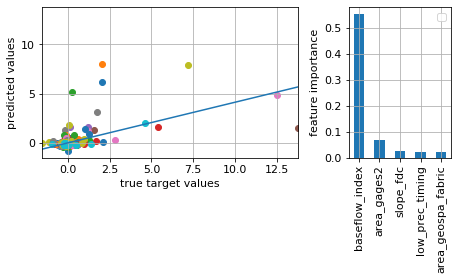

In [58]:
# Make a dictionary for all the X, y values
X = {'X_krig':np.array(df.loc[:,['gauge_lat','gauge_lon']])}
y = {}
z = {}
y_hat = {}
Cross = {}
regressor_attributes = list(attributes.columns.values[0:44])
regressor_attributes.append('basin_hydro_unit')
#regressor_attributes.append('nwm')
#regressor_attributes = ['nwm', 'baseflow_index', 'runoff_ratio', 'slope_fdc', 'stream_elas', 'basin_hydro_unit']
feature_list_short = ['nwm', 'B.I.', 'R.R.', 'F.D.C.', 'elast.', 'HUC']
target='lstmnwm-nwm'
ynormal = True
X[target], y[target] = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat[target], rmse, r2, feature_importance = cross_val_rf(X[target],y[target],regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0)
#                min_weight_fraction_leaf=0, feature_list_short=feature_list_short)


### All NWM state and flux values

In [59]:
# load dynamic features data, which has all the NWM States and Fluxes
with open(data_dir+'dynamic_features_nwm_v2.p', 'rb') as f:
    dynamic_features_data = pkl.load(f)

In [60]:
nwm_columns = list(dynamic_features_data[sample_basin].columns[10:])

In [61]:
nwm_average_values = pd.DataFrame(index=basin_list, columns=nwm_columns)
for b, basin in enumerate(basin_list):
    nwm_average_values.loc[basin,:] = dynamic_features_data[basin].iloc[10:].mean()
nwm_average_values

,streamflow,q_lateral,velocity,qSfcLatRunoff,qBucket,qBtmVertRunoff,ACCET,FIRA,FSA,FSNO,...,SOIL_W1,SOIL_W2,SOIL_W3,SOIL_W4,TRAD,UGDRNOFF,mean_sfcheadsubrt,mean_zwattablrt,max_sfcheadsubrt,max_zwattablrt
01022500,11.80678,0.05726,0.67408,0.00901,0.04956,178.41287,0.16003,53.78358,133.90569,0.30298,...,0.27061,0.28866,0.30100,0.30613,280.38024,0.05956,0.00000,2.00000,0.00000,2.00000
01031500,14.91785,0.09322,0.11252,0.08603,0.01723,62.05605,0.14284,51.75442,128.54072,0.38806,...,0.28084,0.30631,0.32543,0.34309,278.06529,0.01613,0.00000,2.00000,0.00000,2.00000
01047000,20.97725,0.09989,0.76204,0.08411,0.02694,97.03694,0.14900,51.31855,135.75556,0.42473,...,0.23537,0.26322,0.28487,0.30819,277.45750,0.02696,0.00000,2.00000,0.00000,2.00000
01052500,9.32967,0.02324,1.15628,0.00081,0.03600,129.59121,0.14388,48.70902,128.11123,0.43817,...,0.28386,0.30584,0.31811,0.33307,276.81217,0.05022,0.00000,2.00000,0.00000,2.00000
01054200,5.51216,0.01970,0.96970,0.01941,0.01241,44.68099,0.17124,49.85445,142.05464,0.46513,...,0.21850,0.25635,0.28580,0.30695,276.62149,0.07554,0.00000,2.00000,0.00000,2.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11482500,25.29624,0.21110,0.58753,0.01624,0.19905,716.47005,0.14034,67.85576,179.18565,0.05828,...,0.31058,0.31471,0.32340,0.34778,283.74471,0.12721,0.00000,2.00000,0.00000,2.00000
11522500,57.19554,0.06526,1.44764,0.01183,0.05777,207.93827,0.11116,72.13259,174.51202,0.33703,...,0.24413,0.24986,0.25487,0.26544,280.66653,0.26009,0.00000,2.00000,0.00000,2.00000
11523200,11.01348,0.07853,1.11865,0.01893,0.06367,229.19817,0.06387,77.37446,164.46590,0.44909,...,0.17525,0.19248,0.21120,0.25821,278.51080,0.23864,0.00000,2.00000,0.00000,2.00000
11528700,42.45678,0.04810,1.02632,0.00260,0.05117,184.20374,0.16493,71.07061,177.73345,0.30486,...,0.25251,0.26180,0.26651,0.27415,280.68853,0.13078,0.00000,2.00000,0.00000,2.00000


In [62]:
nwm_average_values_soil_M = nwm_average_values.columns[14:18]
nwm_average_values_soil_W = nwm_average_values.columns[18:22]
nwm_average_values_soil_slim = nwm_average_values.copy(deep=True)
nwm_average_values_soil_slim = nwm_average_values_soil_slim.drop(nwm_average_values_soil_M, axis = 1)
nwm_average_values_soil_slim = nwm_average_values_soil_slim.drop(nwm_average_values_soil_W, axis = 1)
nwm_average_values_soil_slim = nwm_average_values_soil_slim.drop(['mean_sfcheadsubrt',
                                'mean_zwattablrt','max_sfcheadsubrt','max_zwattablrt'], axis = 1)
nwm_average_values_soil_slim['Soil_W'] = np.mean(nwm_average_values.loc[:,
                                                    nwm_average_values_soil_W], axis=1)
nwm_average_values_soil_slim['Soil_M'] = np.mean(nwm_average_values.loc[:,
                                                    nwm_average_values_soil_M], axis=1)

nwm_average_values_soil_slim['zwattablrt'] = np.mean(nwm_average_values.loc[:,
                                                    ('mean_zwattablrt','max_zwattablrt')], axis=1)
nwm_average_values_soil_slim['sfcheadsubrt'] = np.mean(nwm_average_values.loc[:,
                                                    ('mean_sfcheadsubrt','max_sfcheadsubrt')], axis=1)

nwm_average_values_soil_slim
nwm_columns_soil_slim = nwm_average_values_soil_slim.columns.values

In [63]:
optimal = [1, 0, 0]
improvements = {}
for ifc, fc in enumerate(flow_categories_very_slim):    
    for imt, mod in enumerate(base_models):
        for imet, metric in enumerate(use_metrics):
            control = met_mat[fc][:,imt,imet]       #metric_values.loc[:,(hyd, metric, 'test')]
            test = met_mat[fc][:,2,imet]
            if optimal[imt] == 1:
                improvements[(fc,mod,metric)] = test-control
            elif optimal[imt] == 0:
                improvements[(fc,mod,metric)] = (np.abs(test)-np.abs(control))

In [64]:
corr = {}
for ifc, fc in enumerate(flow_categories_very_slim):    
    for imt, mod in enumerate(base_models):
        corr[(fc,mod)] = pd.DataFrame(index=nwm_columns_soil_slim, columns=use_metrics)
        for imet, metric in enumerate(use_metrics):
            for i, inpt in enumerate(nwm_columns_soil_slim):
                x = nwm_average_values_soil_slim[inpt].values.astype(float)
                y = improvements[(fc,mod,metric)]
                corr[(fc,mod)].loc[inpt,metric] = np.corrcoef(x, y)[0,1]          

In [65]:
for ifc, fc in enumerate(flow_categories_very_slim):    
    for imt, mod in enumerate(base_models):
        corr[(fc,mod)].rename(columns={use_metrics[0]:short_metric_names[0], use_metrics[1]:short_metric_names[1],
                    use_metrics[2]:short_metric_names[2]})
        corr[(fc,mod)] = corr[(fc,mod)].rename(index={'qSfcLatRunoff':'qLateral', 'qBtmVertRunoff':'qBottom'})

In [66]:
corr

{('all',
  'nwm'):                   NSE Beta-NSE Peak-Timing
 streamflow   -0.07775 -0.19595    -0.08268
 q_lateral    -0.05911 -0.07772     0.00066
 velocity      0.02162 -0.22637    -0.17810
 qLateral     -0.08489 -0.03599     0.04545
 qBucket      -0.02093 -0.10695    -0.05054
 qBottom      -0.02099 -0.10688    -0.05043
 ACCET        -0.06538  0.20278     0.17194
 FIRA          0.11884  0.06064     0.02137
 FSA          -0.04688  0.10443     0.17608
 FSNO          0.13568 -0.16329    -0.24974
 HFX          -0.09701 -0.06467     0.09448
 LH           -0.06350  0.20467     0.17243
 SNEQV         0.01642 -0.23361    -0.25162
 SNOWH         0.02795 -0.25232    -0.28266
 TRAD         -0.13395  0.20074     0.27066
 UGDRNOFF      0.04120 -0.36551    -0.27515
 Soil_W       -0.10206 -0.00721     0.08307
 Soil_M       -0.04145 -0.02312     0.02898
 zwattablrt   -0.05139 -0.14422    -0.10312
 sfcheadsubrt -0.01086  0.01357     0.00958,
 ('all',
  'v0'):                   NSE Beta-NSE Peak-Tim

Text(0, 0.5, 'Correlation')

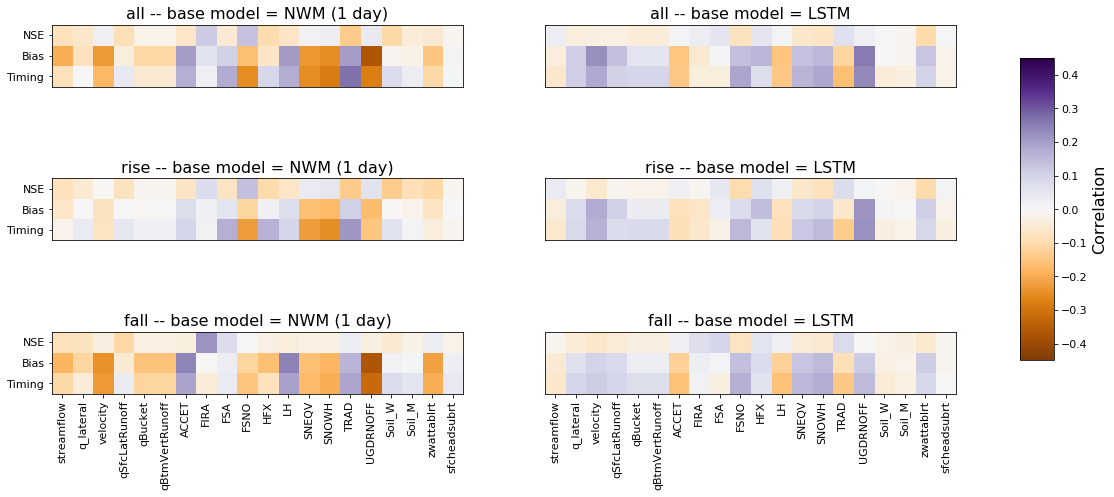

In [67]:
fig, ax = plt.subplots(3,2,figsize=(16,8))
for ifc,fc in enumerate(flow_categories_very_slim):    
    for imt, mod in enumerate(base_models):
        im = ax[ifc,imt].imshow(corr[(fc,mod)].transpose().astype(float),
                       cmap='PuOr',
                      vmax=0.45, vmin=-0.45)
        ax[ifc,imt].set_xticks([])
        ax[ifc,imt].set_yticks([])
        ax[ifc,imt].set_title(f"{fc.replace('_',' ')} -- base model = {base_model_names[imt]}", fontsize=16)
        
ax[2,0].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
ax[2,1].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
ax[2,0].set_xticklabels(nwm_average_values_soil_slim.columns, rotation='vertical')
ax[2,1].set_xticklabels(nwm_average_values_soil_slim.columns, rotation='vertical')

ax[0,0].set_yticks(range(len(use_metrics)))
ax[1,0].set_yticks(range(len(use_metrics)))
ax[2,0].set_yticks(range(len(use_metrics)))
ax[0,0].set_yticklabels(short_metric_names)
ax[1,0].set_yticklabels(short_metric_names)
ax[2,0].set_yticklabels(short_metric_names)

fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.965, 0.24, 0.03, 0.525])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Correlation', fontsize=16)


Text(0, 0.5, 'Correlation')

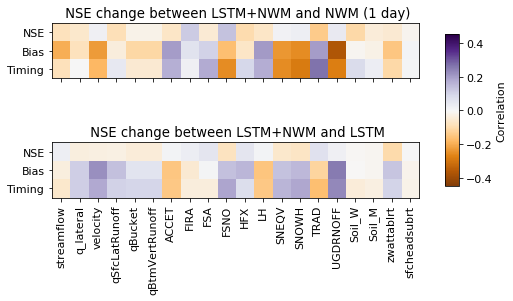

In [68]:
mpl.rcParams.update({'font.size': 11})
fig, ax = plt.subplots(2,1,figsize=(6.5,4.02))
for imt, mod in enumerate(base_models):
    im = ax[imt].imshow(corr[('all',mod)].transpose().astype(float),
                   cmap='PuOr',
                  vmax=0.45, vmin=-0.45)
    ax[imt].set_xticks([])
    ax[imt].set_yticks([])
    ax[imt].set_title(' NSE change between LSTM+NWM and ' + base_model_names[imt])
        
ax[0].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
ax[1].set_xticks(range(len(nwm_average_values_soil_slim.columns)))
ax[0].set_xticklabels([])
ax[1].set_xticklabels(nwm_average_values_soil_slim.columns, rotation='vertical')

ax[0].set_yticks(range(len(use_metrics)))
ax[1].set_yticks(range(len(use_metrics)))
ax[0].set_yticklabels(short_metric_names)
ax[1].set_yticklabels(short_metric_names)

fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.965, 0.24, 0.03, 0.525])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Correlation')

In [69]:
for imt, mod in enumerate(base_models):
    print(np.abs(np.mean(corr[('all',mod)].transpose().astype(float), axis=0)).sort_values())

sfcheadsubrt   0.00409
Soil_W         0.00873
Soil_M         0.01186
HFX            0.02240
qLateral       0.02514
q_lateral      0.04539
qBottom        0.05943
qBucket        0.05947
FIRA           0.06695
FSA            0.07788
FSNO           0.09245
zwattablrt     0.09958
ACCET          0.10311
LH             0.10453
TRAD           0.11248
streamflow     0.11879
velocity       0.12762
SNEQV          0.15627
SNOWH          0.16901
UGDRNOFF       0.19982
dtype: float64
FSA            0.00871
sfcheadsubrt   0.01024
Soil_M         0.01597
Soil_W         0.01661
FIRA           0.01853
streamflow     0.02183
qBottom        0.03874
qBucket        0.03876
zwattablrt     0.04262
q_lateral      0.06286
TRAD           0.07198
qLateral       0.07330
SNEQV          0.07861
FSNO           0.08339
SNOWH          0.08948
ACCET          0.09220
LH             0.09260
HFX            0.09429
velocity       0.12498
UGDRNOFF       0.16914
dtype: float64


# Regional analysis

In [70]:
unique_hydro_unit = attributes.basin_hydro_unit.unique()
nregions = len(unique_hydro_unit)

In [71]:
def calc_wilcoxon_huc(huc):
    _, p_nwm = st.wilcoxon(huc_stat['nwm'][huc], huc_stat['v2'][huc])
    _, p_v0 = st.wilcoxon(huc_stat['v0'][huc], huc_stat['v2'][huc])
    return [p_nwm,p_v0]    

In [72]:
# Need an array with huc,metric,basin,model
mod_types = ['v0', 'v2', 'nwm']

huc_stat_dict = {m:pd.DataFrame(index=unique_hydro_unit, columns=mod_types) for m in metric_names}
huc_sig_dict = {m:pd.DataFrame(index=unique_hydro_unit, columns=['v0','nwm', 'n']) for m in metric_names}

for imet, nmet in enumerate([0,6,11]):
    
    huc_stat = {model:{huc:[] for huc in unique_hydro_unit} for model in mod_types}

    for ihuc, huc in enumerate(unique_hydro_unit):
        for ib, b in enumerate(basin_list):
            if attributes.loc[int(b), 'basin_hydro_unit'] == huc:
                for imod, mod_name in enumerate(mod_types):
                    huc_stat[mod_name][huc].append(ensemble_metric_dictionary[mod_name][ib,nmet])
        for imod, mod_name in enumerate(mod_types):
            huc_stat_dict[metric_names[imet]].loc[huc,mod_name] = np.mean(huc_stat[mod_name][huc])
            
    for ihuc, huc in enumerate(unique_hydro_unit):
        p_nwm,p_v0 = calc_wilcoxon_huc(huc)
        huc_sig_dict[metric_names[imet]].loc[huc,'nwm'] = p_nwm
        huc_sig_dict[metric_names[imet]].loc[huc,'v0'] = p_v0
        huc_sig_dict[metric_names[imet]].loc[huc,'n'] = len(huc_stat[mod_name][huc])

for m in metric_names:
    huc_sig_dict[m] = huc_sig_dict[m].sort_index()
    huc_stat_dict[m] = huc_stat_dict[m].sort_index()

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [79]:
huc_stat_dict

{'Nash-Sutcliffe Efficiency':         v0      v2      nwm
 01 0.78126 0.78456  0.61806
 02 0.70822 0.73724  0.49219
 03 0.70801 0.70858  0.55940
 04 0.71238 0.68961  0.41345
 05 0.73444 0.74391  0.63217
 06 0.79346 0.79907  0.69502
 07 0.70100 0.70512  0.46030
 08 0.69424 0.67348  0.61203
 09 0.28411 0.39866  0.29106
 10 0.57466 0.45761 -0.06046
 11 0.62773 0.56257  0.31163
 12 0.35123 0.32722  0.27728
 13 0.62093 0.63243  0.23574
 14 0.80038 0.74330  0.50408
 15 0.44683 0.33616 -0.01727
 16 0.72321 0.70611  0.22194
 17 0.81491 0.80689  0.67068
 18 0.75109 0.73869  0.58718,
 'Total Bias':          v0       v2      nwm
 01  0.07764  0.06614 -0.04713
 02  0.03342  0.03248  0.02516
 03 -0.01130 -0.01625  0.01517
 04  0.06122  0.04816  0.00473
 05  0.03404  0.02904 -0.04016
 06 -0.00086  0.00013 -0.01340
 07  0.08222  0.09494  0.11421
 08 -0.03813 -0.02980  0.00825
 09  0.07326  0.08552 -0.16034
 10  0.05508  0.08423  0.14076
 11  0.00646  0.04392  0.04862
 12 -0.02016 -0.00598 -0.00649
 1

In [74]:
huc_stat_dict

{'Nash-Sutcliffe Efficiency':         v0      v2      nwm
 01 0.78126 0.78456  0.61806
 02 0.70822 0.73724  0.49219
 03 0.70801 0.70858  0.55940
 04 0.71238 0.68961  0.41345
 05 0.73444 0.74391  0.63217
 06 0.79346 0.79907  0.69502
 07 0.70100 0.70512  0.46030
 08 0.69424 0.67348  0.61203
 09 0.28411 0.39866  0.29106
 10 0.57466 0.45761 -0.06046
 11 0.62773 0.56257  0.31163
 12 0.35123 0.32722  0.27728
 13 0.62093 0.63243  0.23574
 14 0.80038 0.74330  0.50408
 15 0.44683 0.33616 -0.01727
 16 0.72321 0.70611  0.22194
 17 0.81491 0.80689  0.67068
 18 0.75109 0.73869  0.58718,
 'Total Bias':          v0       v2      nwm
 01  0.07764  0.06614 -0.04713
 02  0.03342  0.03248  0.02516
 03 -0.01130 -0.01625  0.01517
 04  0.06122  0.04816  0.00473
 05  0.03404  0.02904 -0.04016
 06 -0.00086  0.00013 -0.01340
 07  0.08222  0.09494  0.11421
 08 -0.03813 -0.02980  0.00825
 09  0.07326  0.08552 -0.16034
 10  0.05508  0.08423  0.14076
 11  0.00646  0.04392  0.04862
 12 -0.02016 -0.00598 -0.00649
 1

# Split by if calibrated basin

In [75]:
df.groupby('calibrated')['lstmnwm-nwm'].mean()

calibrated
False   0.57020
True    0.17708
Name: lstmnwm-nwm, dtype: float64

calibrated
False   0.13869
True    0.48785
Name: nwm, dtype: float64
calibrated
False   0.45873
True    0.62856
Name: nwm, dtype: float64
calibrated
False   0.76924
True    0.94170
Name: nwm, dtype: float64
calibrated
False    -8.74918
True    -10.81832
Name: nwm, dtype: float64
calibrated
False   0.70889
True    0.66493
Name: v2, dtype: float64
calibrated
False   0.72251
True    0.74578
Name: v2, dtype: float64
calibrated
False   0.89758
True    0.92329
Name: v2, dtype: float64
calibrated
False    0.42010
True    -3.07345
Name: v2, dtype: float64
significance test for
NWM MannwhitneyuResult(statistic=7640.0, pvalue=6.280316715470989e-06)
LSTM + NWM MannwhitneyuResult(statistic=11177.0, pvalue=0.17051598657894718)
diff MannwhitneyuResult(statistic=6728.0, pvalue=7.675757676632504e-08)


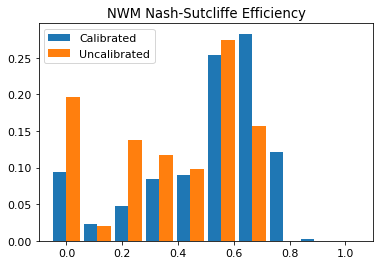

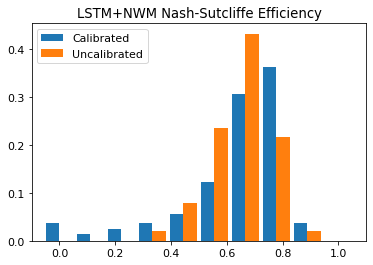

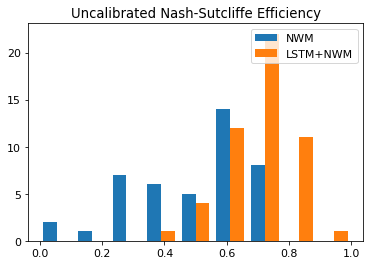

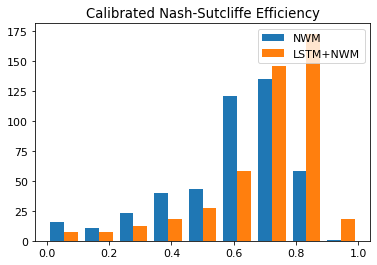

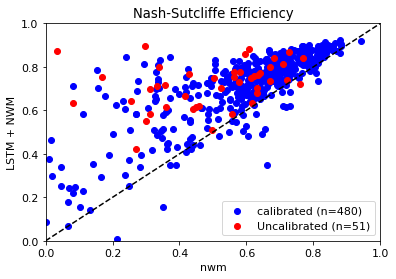

calibrated
False   0.01368
True    0.01692
Name: nwm, dtype: float64
calibrated
False   -0.04919
True    -0.00559
Name: nwm, dtype: float64
calibrated
False   2.04709
True    2.58056
Name: nwm, dtype: float64
calibrated
False   -0.56028
True    -0.64917
Name: nwm, dtype: float64
calibrated
False   0.01789
True    0.03497
Name: v2, dtype: float64
calibrated
False   -0.00452
True     0.02358
Name: v2, dtype: float64
calibrated
False   0.23080
True    0.97943
Name: v2, dtype: float64
calibrated
False   -0.10958
True    -0.21681
Name: v2, dtype: float64
significance test for
NWM MannwhitneyuResult(statistic=10267.0, pvalue=0.03356018414890447)
LSTM + NWM MannwhitneyuResult(statistic=10818.0, pvalue=0.09700705017876654)
diff MannwhitneyuResult(statistic=10945.0, pvalue=0.11976580140988846)


IndexError: index 10 is out of bounds for axis 0 with size 10

In [76]:
for imet, nmet in enumerate([0,6,11]):
    attributes2 = attributes.copy(deep=True)
    attributes2['nwm'] = [np.nan]*attributes2.shape[0]
    attributes2['v0'] = [np.nan]*attributes2.shape[0]
    attributes2['v2'] = [np.nan]*attributes2.shape[0]
    attributes2['lstmnwm-nwm'] = [np.nan]*attributes2.shape[0]
    r=0
    for i, b in enumerate(basin_list):
        attributes2.loc[int(b), 'v0'] = ensemble_metric_dictionary['v0'][i,nmet]
        attributes2.loc[int(b), 'v2'] = ensemble_metric_dictionary['v2'][i,nmet]
        attributes2.loc[int(b), 'nwm'] = ensemble_metric_dictionary['nwm'][i,nmet]
        attributes2.loc[int(b), 'lstmnwm-nwm'] = \
                           ensemble_metric_dictionary['v2'][i,nmet] - \
                           ensemble_metric_dictionary['nwm'][i,nmet]
    # Remove any rows with nan
    df = attributes2.dropna()

    for model_type in ['nwm','v2']:
        print(df.groupby('calibrated')[model_type].mean())
        print(df.groupby('calibrated')[model_type].median())
        print(df.groupby('calibrated')[model_type].max())
        print(df.groupby('calibrated')[model_type].min())
    
    cal_bas_nwm = []
    cal_bas_v0 = []
    cal_bas_v2 = []
    uncal_bas_nwm = []
    uncal_bas_v0 = []
    uncal_bas_v2 = []
    diff_cal = []
    diff_uncal = []
    for ib, b in enumerate(basin_list):
        if int(b) in list(df.index.values):
            if df.loc[int(b),'calibrated']:
                cal_bas_nwm.append(df.loc[int(b),'nwm'])
                cal_bas_v0.append(df.loc[int(b),'v0'])
                cal_bas_v2.append(df.loc[int(b),'v2'])
                diff_cal.append(df.loc[int(b),'lstmnwm-nwm'])
            else:
                uncal_bas_nwm.append(df.loc[int(b),'nwm'])
                uncal_bas_v0.append(df.loc[int(b),'v0'])
                uncal_bas_v2.append(df.loc[int(b),'v2'])
                diff_uncal.append(df.loc[int(b),'lstmnwm-nwm'])
    # Check for significance between the two samples.
    print('significance test for')
    print('NWM', st.mannwhitneyu(cal_bas_nwm, uncal_bas_nwm))
    print('LSTM + NWM', st.mannwhitneyu(cal_bas_v2, uncal_bas_v2))

    print('diff', st.mannwhitneyu(diff_cal, diff_uncal))

    
    # Histogram for NWM
    for cal_set, uncal_set, model_type in zip([cal_bas_nwm, cal_bas_v2],
                                              [uncal_bas_nwm, uncal_bas_v2],
                                              ['NWM','LSTM+NWM']):
        cal_set = [0 if x < 0 else x for x in cal_set]
        uncal_set = [0 if x < 0 else x for x in uncal_set]
        n_bins=10
        bin_breaks = np.linspace(0, 1, n_bins)
        A = []
        B = []
        for bb in range(10):
            A_count=0
            for calval in cal_set:
                if calval >= bin_breaks[bb]:
                    if calval < bin_breaks[bb+1]:
                        A_count+=1
            B_count=0
            for uncalval in uncal_set:
                if uncalval >= bin_breaks[bb]:
                    if uncalval < bin_breaks[bb+1]:
                        B_count+=1
            A.append(A_count/len(cal_set))
            B.append(B_count/len(uncal_set))
#         A = st.relfreq(cal_set, numbins=n_bins)        
#         B = st.relfreq(uncal_set, numbins=n_bins)
        ax = plt.subplot()
        bar_width = 1 / n_bins / 2
        ax.bar(bin_breaks - bar_width/2, A, label='Calibrated', width=bar_width, align='center')
        ax.bar(bin_breaks + bar_width/2, B, label='Uncalibrated', width=bar_width, align='center')
        plt.xlim([-.1, 1.1])
        plt.title(model_type+' '+use_metric_names[imet])
        plt.legend(loc='upper left')
        plt.show()
        plt.close()
    
    # Uncalibrated
    bins = np.linspace(met_lims[nmet][0], met_lims[nmet][1], 10)
    plt.hist([uncal_bas_nwm, uncal_bas_v2], bins, label=['NWM', 'LSTM+NWM'])
    plt.title('Uncalibrated '+use_metric_names[imet])
    plt.legend(loc='upper right')
    plt.show()
    plt.close()
    # Calibrated
    bins = np.linspace(met_lims[nmet][0], met_lims[nmet][1], 10)
    plt.hist([cal_bas_nwm, cal_bas_v2], bins, label=['NWM', 'LSTM+NWM'])
    plt.title('Calibrated '+use_metric_names[imet])
    plt.legend(loc='upper right')
    plt.show()
    plt.close()

    
    plt_limz = met_lims[nmet]
    plt.scatter(cal_bas_nwm, cal_bas_v2, c='b', label='calibrated (n=480)')
    plt.scatter(uncal_bas_nwm, uncal_bas_v2, c='r', label='Uncalibrated (n=51)')
    plt.plot(plt_limz, plt_limz, 'k--')
    plt.ylim(plt_limz)
    plt.xlim(plt_limz)
    plt.title(use_metric_names[imet])
    plt.ylabel('LSTM + NWM')
    plt.xlabel('nwm')
    plt.legend()
    plt.show()
    plt.close()

In [ ]:
basin_color = []
for ib, b in enumerate(basin_list):
    if int(b) in list(df.index.values):
        if df.loc[int(b),'calibrated']:
            basin_color.append('b')
        else:
            basin_color.append('r')
plt.scatter(df['gauge_lon'], df['gauge_lat'], color=basin_color)